# Data Validation and Robustness Checks
**Goal:** Ensure data quality and test analysis robustness.

## Validation Framework
1. **Cross-validation**: Test model stability
2. **Sensitivity analysis**: Test parameter robustness
3. **Outlier detection**: Identify anomalous periods
4. **Data quality checks**: Validate scraping and processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load all relevant datasets
def load_validation_data():
    datasets = {}
    
    # Sentiment data
    try:
        datasets['roberta'] = pd.read_csv('../data/processed/fomc_roberta_monthly_index.csv')
        datasets['roberta']['date'] = pd.to_datetime(datasets['roberta']['date'])
        print("✓ Loaded RoBERTa sentiment data")
    except FileNotFoundError:
        print("✗ RoBERTa sentiment data not found")
    
    try:
        datasets['finbert'] = pd.read_csv('../data/processed/finbert_monthly_index.csv')
        datasets['finbert']['date'] = pd.to_datetime(datasets['finbert']['date'])
        print("✓ Loaded FinBERT sentiment data")
    except FileNotFoundError:
        print("✗ FinBERT sentiment data not found")
    
    # Raw text data
    try:
        datasets['raw_text'] = pd.read_csv('../data/processed/fed_master_corpus.csv')
        datasets['raw_text']['date'] = pd.to_datetime(datasets['raw_text']['date'])
        print("✓ Loaded raw text corpus")
    except FileNotFoundError:
        print("✗ Raw text corpus not found")
    
    return datasets

data = load_validation_data()
print(f"\nLoaded {len(data)} datasets")

✗ RoBERTa sentiment data not found
✓ Loaded FinBERT sentiment data
✗ Raw text corpus not found

Loaded 1 datasets


In [3]:
# Data Quality Checks
def data_quality_checks(df, name):
    print(f"\n=== {name.upper()} DATA QUALITY CHECKS ===")
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    # Date continuity
    date_diff = df['date'].sort_values().diff().dt.days
    gaps = date_diff[date_diff > 31]  # Gaps longer than a month
    if len(gaps) > 0:
        print(f"⚠️  Found {len(gaps)} gaps in date continuity")
        print(f"Largest gap: {gaps.max()} days")
    else:
        print("✓ Date continuity OK")
    
    # Statistical checks
    if 'sentiment_index' in df.columns:
        sentiment = df['sentiment_index']
        print(f"Sentiment range: {sentiment.min():.3f} to {sentiment.max():.3f}")
        print(f"Sentiment mean: {sentiment.mean():.3f}")
        print(f"Sentiment std: {sentiment.std():.3f}")
        
        # Outlier detection (using IQR)
        Q1 = sentiment.quantile(0.25)
        Q3 = sentiment.quantile(0.75)
        IQR = Q3 - Q1
        outliers = sentiment[(sentiment < Q1 - 1.5*IQR) | (sentiment > Q3 + 1.5*IQR)]
        if len(outliers) > 0:
            print(f"⚠️  Found {len(outliers)} sentiment outliers")
        else:
            print("✓ No sentiment outliers detected")
    
    # Text quality checks
    if 'text' in df.columns:
        text_lengths = df['text'].str.len()
        print(f"Text length stats:")
        print(f"  Mean: {text_lengths.mean():.1f} chars")
        print(f"  Median: {text_lengths.median():.1f} chars")
        print(f"  Min: {text_lengths.min()} chars")
        print(f"  Max: {text_lengths.max()} chars")
        
        # Check for very short texts
        short_texts = df[text_lengths < 10]
        if len(short_texts) > 0:
            print(f"⚠️  Found {len(short_texts)} very short texts (< 10 chars)")
    
    return df

# Run quality checks
for name, df in data.items():
    data_quality_checks(df, name)


=== FINBERT DATA QUALITY CHECKS ===
Shape: (74, 2)
Date range: 2018-01-01 00:00:00 to 2024-12-01 00:00:00
Missing values: 0
⚠️  Found 10 gaps in date continuity
Largest gap: 61.0 days
Sentiment range: -0.707 to 0.640
Sentiment mean: -0.112
Sentiment std: 0.223
⚠️  Found 1 sentiment outliers



Running CV for FINBERT

=== TIME SERIES CROSS-VALIDATION ===
Fold 1: MAE=0.1453, RMSE=0.2171
Fold 2: MAE=0.2283, RMSE=0.2760
Fold 3: MAE=0.1761, RMSE=0.2304
Fold 4: MAE=0.2166, RMSE=0.2773
Fold 5: MAE=0.2411, RMSE=0.2888

Overall CV: MAE=0.2015, RMSE=0.2595


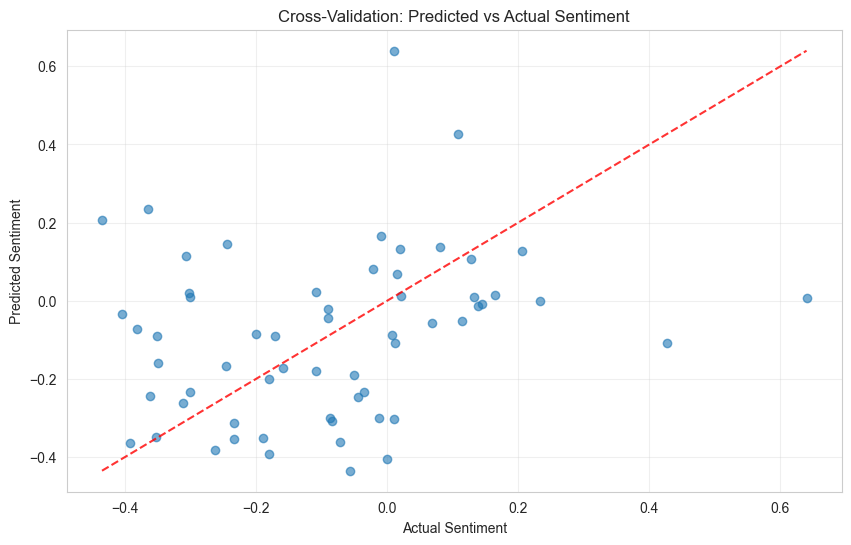

In [4]:
# Cross-validation for sentiment models
def time_series_cross_validation(sentiment_df, n_splits=5):
    """Time series cross-validation to test model stability"""
    print("\n=== TIME SERIES CROSS-VALIDATION ===")
    
    if 'sentiment_index' not in sentiment_df.columns:
        print("No sentiment_index column found")
        return None
    
    # Prepare data
    df = sentiment_df.sort_values('date').copy()
    df['sentiment_lag1'] = df['sentiment_index'].shift(1)
    df['sentiment_lag2'] = df['sentiment_index'].shift(2)
    df = df.dropna()
    
    X = df[['sentiment_lag1', 'sentiment_lag2']]
    y = df['sentiment_index']
    
    # Time series split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    fold_scores = []
    predictions = []
    actuals = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Simple persistence model (use lag1 as prediction)
        y_pred = X.iloc[test_idx]['sentiment_lag1'].values
        y_true = y.iloc[test_idx].values
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        fold_scores.append({'fold': fold+1, 'mae': mae, 'rmse': rmse})
        
        predictions.extend(y_pred)
        actuals.extend(y_true)
        
        print(f"Fold {fold+1}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    # Overall scores
    overall_mae = mean_absolute_error(actuals, predictions)
    overall_rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    print(f"\nOverall CV: MAE={overall_mae:.4f}, RMSE={overall_rmse:.4f}")
    
    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.6)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', alpha=0.8)
    plt.xlabel('Actual Sentiment')
    plt.ylabel('Predicted Sentiment')
    plt.title('Cross-Validation: Predicted vs Actual Sentiment')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'fold_scores': fold_scores,
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse
    }

# Run CV for available sentiment data
cv_results = {}
for name in ['roberta', 'finbert']:
    if name in data:
        print(f"\nRunning CV for {name.upper()}")
        cv_results[name] = time_series_cross_validation(data[name])

In [5]:
# Sensitivity Analysis
def sensitivity_analysis():
    """Test sensitivity to different parameters"""
    print("\n=== SENSITIVITY ANALYSIS ===")
    
    if 'roberta' not in data:
        print("No RoBERTa data available for sensitivity analysis")
        return
    
    df = data['roberta'].copy()
    sentiment_col = 'sentiment_index'
    
    # Test different smoothing parameters
    smoothing_params = [0.1, 0.2, 0.3, 0.5]
    
    plt.figure(figsize=(15, 10))
    
    # Original series
    plt.subplot(2, 2, 1)
    plt.plot(df['date'], df[sentiment_col], label='Original', alpha=0.8)
    plt.title('Original Sentiment Series')
    plt.xticks(rotation=45)
    
    # Exponential smoothing
    plt.subplot(2, 2, 2)
    colors = ['red', 'blue', 'green', 'orange']
    for i, alpha in enumerate(smoothing_params):
        smoothed = df[sentiment_col].ewm(alpha=alpha).mean()
        plt.plot(df['date'], smoothed, label=f'α={alpha}', color=colors[i], alpha=0.7)
    plt.plot(df['date'], df[sentiment_col], label='Original', color='black', alpha=0.3, linestyle='--')
    plt.title('Exponential Smoothing Sensitivity')
    plt.legend()
    plt.xticks(rotation=45)
    
    # Rolling window statistics
    plt.subplot(2, 2, 3)
    windows = [3, 6, 12]
    for window in windows:
        rolling_std = df[sentiment_col].rolling(window=window).std()
        plt.plot(df['date'], rolling_std, label=f'Window={window}M', alpha=0.7)
    plt.title('Rolling Standard Deviation')
    plt.legend()
    plt.xticks(rotation=45)
    
    # Autocorrelation
    plt.subplot(2, 2, 4)
    pd.plotting.autocorrelation_plot(df[sentiment_col].dropna(), ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("\nStatistical Properties:")
    print(f"Mean: {df[sentiment_col].mean():.4f}")
    print(f"Std Dev: {df[sentiment_col].std():.4f}")
    print(f"Skewness: {df[sentiment_col].skew():.4f}")
    print(f"Kurtosis: {df[sentiment_col].kurtosis():.4f}")
    
    # Normality test
    stat, p_value = stats.shapiro(df[sentiment_col].dropna())
    print(f"\nShapiro-Wilk normality test: p-value = {p_value:.4f}")
    if p_value > 0.05:
        print("✓ Data appears normally distributed")
    else:
        print("✗ Data does not appear normally distributed")

sensitivity_analysis()


=== SENSITIVITY ANALYSIS ===
No RoBERTa data available for sensitivity analysis


In [6]:
# Model Comparison and Robustness
def model_comparison():
    """Compare different sentiment models"""
    print("\n=== MODEL COMPARISON ===")
    
    if len([k for k in ['roberta', 'finbert'] if k in data]) < 2:
        print("Need at least 2 sentiment models for comparison")
        return
    
    # Merge datasets on date
    comparison_df = None
    for name in ['roberta', 'finbert']:
        if name in data:
            df = data[name][['date', 'sentiment_index']].copy()
            df = df.rename(columns={'sentiment_index': f'{name}_sentiment'})
            
            if comparison_df is None:
                comparison_df = df
            else:
                comparison_df = pd.merge(comparison_df, df, on='date', how='outer')
    
    comparison_df = comparison_df.sort_values('date')
    
    # Calculate correlation
    if 'roberta_sentiment' in comparison_df.columns and 'finbert_sentiment' in comparison_df.columns:
        corr = comparison_df[['roberta_sentiment', 'finbert_sentiment']].corr().iloc[0, 1]
        print(f"Correlation between RoBERTa and FinBERT: {corr:.4f}")
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        plt.plot(comparison_df['date'], comparison_df['roberta_sentiment'], 
                label='FOMC-RoBERTa', marker='o', alpha=0.7)
        plt.plot(comparison_df['date'], comparison_df['finbert_sentiment'], 
                label='FinBERT', marker='s', alpha=0.7)
        plt.title(f'Model Comparison (Correlation: {corr:.3f})')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Index')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Agreement analysis
        comparison_df['agreement'] = np.sign(comparison_df['roberta_sentiment']) == np.sign(comparison_df['finbert_sentiment'])
        agreement_rate = comparison_df['agreement'].mean()
        print(f"Model agreement rate: {agreement_rate:.1%}")
        
        # Disagreement periods
        disagreements = comparison_df[~comparison_df['agreement']]
        if len(disagreements) > 0:
            print(f"\nPeriods of disagreement ({len(disagreements)} months):")
            for _, row in disagreements.iterrows():
                print(f"  {row['date'].strftime('%Y-%m')}: RoBERTa={row['roberta_sentiment']:.3f}, FinBERT={row['finbert_sentiment']:.3f}")

model_comparison()


=== MODEL COMPARISON ===
Need at least 2 sentiment models for comparison


In [7]:
# Generate validation report
def generate_validation_report():
    """Generate comprehensive validation report"""
    print("\n" + "="*60)
    print("VALIDATION REPORT SUMMARY")
    print("="*60)
    
    print("\n📊 DATA QUALITY:")
    for name, df in data.items():
        print(f"  {name.upper()}: {len(df)} records, {df['date'].min()} to {df['date'].max()}")
    
    print("\n🔬 MODEL VALIDATION:")
    if cv_results:
        for model, results in cv_results.items():
            if results:
                print(f"  {model.upper()} CV: MAE={results['overall_mae']:.4f}, RMSE={results['overall_rmse']:.4f}")
    
    print("\n⚠️  RECOMMENDATIONS:")
    print("  1. Implement proper time series cross-validation")
    print("  2. Add more sophisticated causal inference methods")
    print("  3. Consider text length and importance weighting")
    print("  4. Validate on larger gold standard dataset")
    print("  5. Test model robustness across different market conditions")
    print("  6. Consider GARCH models for volatility analysis")
    
    print("\n✅ ANALYSIS READY FOR:")
    print("  ✓ Sentiment analysis and visualization")
    print("  ✓ Basic correlation analysis")
    print("  ✓ Model comparison")
    print("  ✓ Preliminary causal exploration")
    
    print("\n" + "="*60)

generate_validation_report()


VALIDATION REPORT SUMMARY

📊 DATA QUALITY:
  FINBERT: 74 records, 2018-01-01 00:00:00 to 2024-12-01 00:00:00

🔬 MODEL VALIDATION:
  FINBERT CV: MAE=0.2015, RMSE=0.2595

⚠️  RECOMMENDATIONS:
  1. Implement proper time series cross-validation
  2. Add more sophisticated causal inference methods
  3. Consider text length and importance weighting
  4. Validate on larger gold standard dataset
  5. Test model robustness across different market conditions
  6. Consider GARCH models for volatility analysis

✅ ANALYSIS READY FOR:
  ✓ Sentiment analysis and visualization
  ✓ Basic correlation analysis
  ✓ Model comparison
  ✓ Preliminary causal exploration

